# RSA

In [1]:
from pathlib import Path
import pickle

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from fsk.config import layers

In [2]:
rsa_path = Path('/Users/m_vilas/projects/fsk-multimodal/results/rsa')

In [48]:
models = [
    'clip_img', 'clip_txt', 'vilt_multi', 'albef_img', 'albef_txt', 'albef_multi',
    'bert_concepts', 'bert_definition', 'gpt_concepts', 'gpt_definition', 'vit_16', 'vit_32'
]
hs_types = ['concepts', 'definition']
stream_map = {
    'clip_img': 'image', 'clip_txt': 'text', 'vilt_multi': 'multimodal',
    'albef_img': 'image', 'albef_txt': 'text', 'albef_multi': 'multimodal',
    'bert_concepts': 'text', 'bert_definition': 'text', 'gpt_concepts': 'text',
    'gpt_definition': 'text', 'vit_16': 'image', 'vit_32': 'image'
}
feature_types = [
    'all', 'taxonomic', 'function', 'encyclopaedic', 'visual_perceptual', 'other_perceptual'
]

In [49]:
data = []
for model in models:
    if 'concepts' in model:
        hs_type = 'concepts'
    elif 'definition' in model:
        hs_type = 'definition'
    else:
        hs_type = None
        
    for ft in feature_types:
        if ft == 'all':
            file = rsa_path / f'sem_mcrae_{model}.pkl'
        else:
            file = rsa_path / f'sem_mcrae_{model}_{ft}.pkl'
    
        with open(file, 'rb') as f:
            m_data = pickle.load(f)

        for l_data in m_data:
            layer = l_data[1].split('_')[-1]
            if layer.endswith('c-out'):
                layer = '12'
            data.append([model, layer, stream_map[model], ft, hs_type, l_data[2], l_data[3]])

data = pd.DataFrame(
    data, columns=['model', 'layer', 'stream', 'feature', 'hs_type', 'rsa', 'p_val']
)
data

,model,layer,stream,feature,hs_type,rsa,p_val
0,clip_img,0,image,all,None,0.099411,0.0
1,clip_img,1,image,all,None,0.132844,0.0
2,clip_img,2,image,all,None,0.166758,0.0
3,clip_img,3,image,all,None,0.205345,0.0
4,clip_img,4,image,all,None,0.214135,0.0
...,...,...,...,...,...,...,...
811,vit_32,7,image,other_perceptual,None,0.158901,0.0
812,vit_32,8,image,other_perceptual,None,0.156352,0.0
813,vit_32,9,image,other_perceptual,None,0.129223,0.0
814,vit_32,10,image,other_perceptual,None,0.086151,0.0


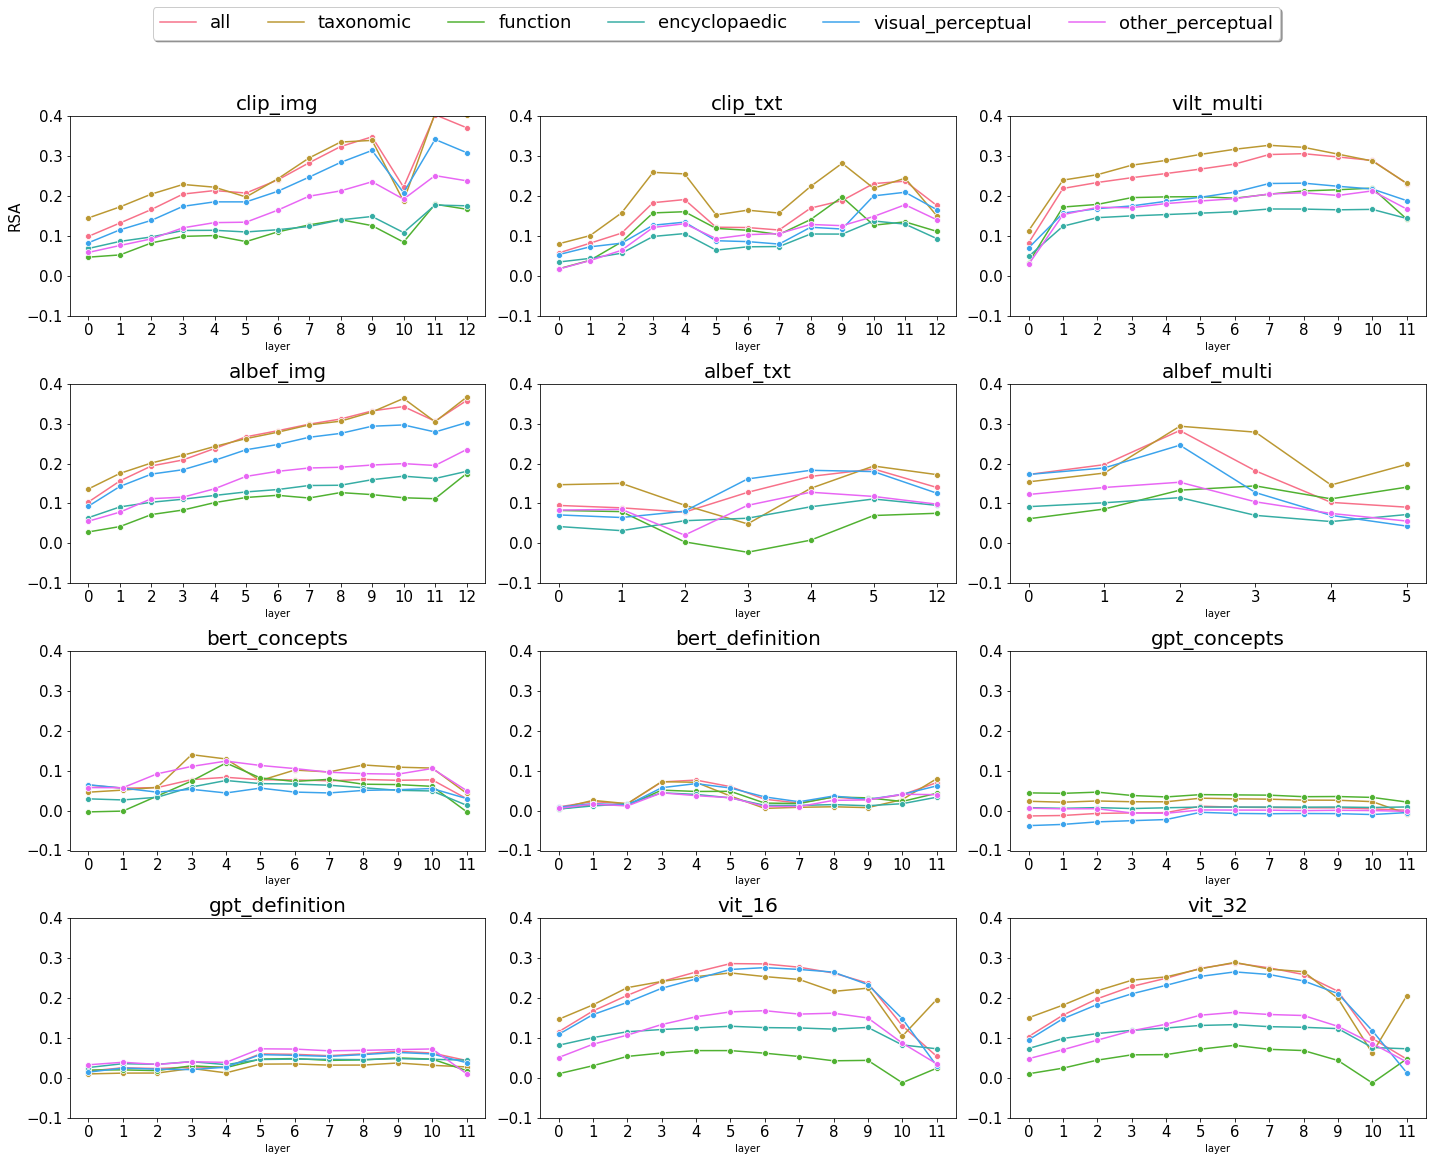

In [50]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20,15))
for m, ax in zip(models, axes.flat):
    m_data = data.loc[data['model']==m]
    sns.lineplot(
        x='layer', y='rsa', hue='feature', data=m_data, 
        marker='o', dashes=False, ax=ax, palette="husl"
    )
    #sns.lineplot(data=m[0].xs(m[1]), markers=['o', 'o', 'o', 'o', 'o'], dashes=False, ax=ax)
    #chance_info =  chance_level.loc[chance_level['model'] == m].groupby('layer').mean().reset_index()
#     chance_info =  chance_level.loc[chance_level['model'] == m].reset_index()
#     sns.lineplot(x='layer', y='rsa', data=chance_info, linestyle='--', color='black', ax=ax)
    ax.set(ylim=(-0.1, 0.40))
    ax.set_title(m, fontsize=20)
    ax.tick_params(axis='y', labelsize=15)
    ax.tick_params(axis='x', labelsize=15)
    ax.get_legend().remove()
    ax.set(ylabel=None)
#     yticks = ax.yaxis.get_major_ticks() 
#     yticks[0].label1.set_visible(False)

axes.flat[0].set_ylabel('RSA', fontsize=15)
lines, labels = axes.flat[0].get_legend_handles_labels()
lgd = fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.08), ncol=6, fancybox=True, shadow=True, fontsize=18)

plt.tight_layout()
plt.show()

In [33]:
models

['clip_img',
 'clip_txt',
 'vilt_multi_concepts',
 'bert_concepts',
 'bert_definition',
 'gpt_concepts',
 'gpt_definition',
 'vit_16',
 'vit_32']

In [53]:
mean_data = data.groupby(['model', 'feature']).mean().reset_index()
mean_data1 = mean_data.loc[mean_data['model'].isin(['vit_16', 'vit_32', 'clip_img', 'albef_img', 'vilt_multi'])]
#mean_data2 = mean_data.loc[mean_data['model'].isin(['vit_16', 'clip_img', 'vilt_multi_concepts'])]
mean_data1

,model,feature,rsa,p_val
0,albef_img,all,0.261345,0.000000
1,albef_img,encyclopaedic,0.131762,0.000000
2,albef_img,function,0.102016,0.000000
3,albef_img,other_perceptual,0.157757,0.000000
4,albef_img,taxonomic,0.267884,0.000000
5,albef_img,visual_perceptual,0.230463,0.000000
30,clip_img,all,0.247886,0.000000
31,clip_img,encyclopaedic,0.121940,0.000000
32,clip_img,function,0.108298,0.000000
33,clip_img,other_perceptual,0.162695,0.000000


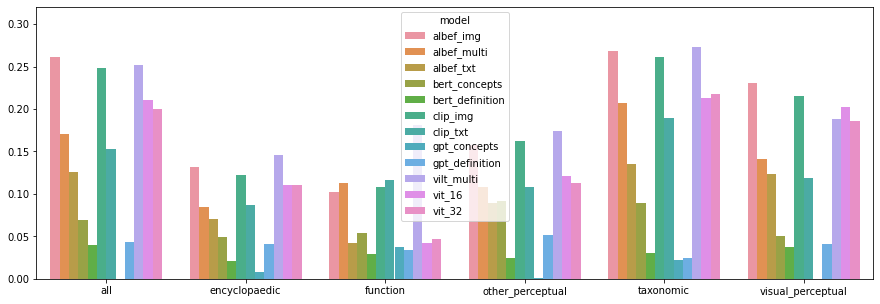

In [56]:
fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(x='feature', y='rsa', hue='model', data=mean_data)
#ax.set_xticklabels(rotation = 20)
ax.set(ylim=(0, 0.32))
ax.set(xlabel=None, ylabel=None)
#axes.flat[0].set(xlabel=None, ylabel='RSA')
#plt.tight_layout()
plt.show()
#fig.savefig(figures_path / 'figure_3.png', dpi=300)